This notebook estimates bus arrival time using gaussian processes.

First off lets get some libraries into scope, set the seed and load the data.

In [199]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler

sns.set(style="darkgrid")
np.random.seed(1)
df = pd.read_pickle('data.pkl')

That's a lot of data (4 gb). Let's look at just one trajectory and plot the coordinates

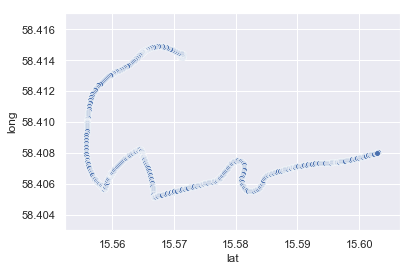

In [59]:
traj_one_df = df[df.traj == 1]
traj_one_df = traj_one_df[1:681] # Filter out all the garbage data on indicies 3464837 etc
sns.scatterplot(x="lat", y="long", data=traj_one_df)

It looks nice! We can also visualise the segments and their time remaining to next bus stop

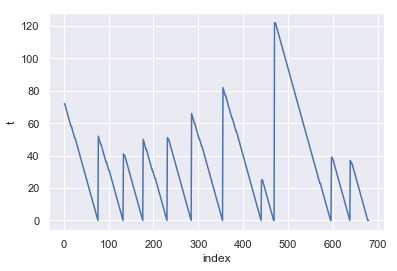

In [49]:
# All segments
traj_one_df['index'] = traj_one_df.index
sns.lineplot(data=test, x='index', y='t')

Let's try to learn the synchronisation function for segment two

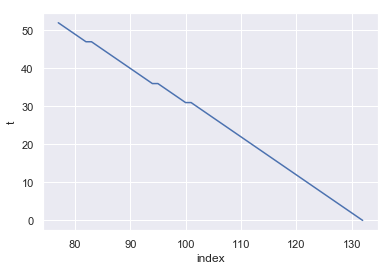

In [61]:
# The first segment
seg2 = traj_one_df[traj_one_df.seg == 2]
sns.lineplot(data=seg1, x='index', y='t')

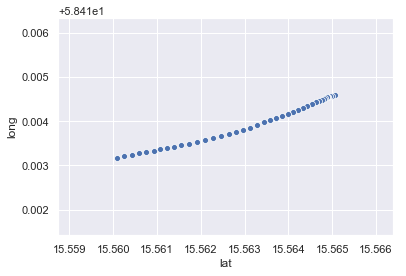

In [62]:
sns.scatterplot(x="lat", y="long", data=seg2)

In [ ]:
For this we need to learn the function f : R^2 -> [0, 1] so we will use a bivariate GP model

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -64.577447
  Number of iterations: 51
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -64.577447
  Number of iterations: 51
  Number of functions evaluations: 63


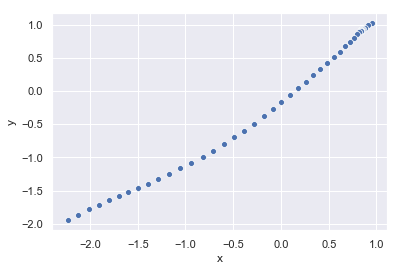

In [248]:
k = gpflow.kernels.Matern52(2, lengthscales=3, ARD=True)
Y = 1 - np.array(seg2['t']).reshape(56,1) / seg2['t'].max() # Map to progress
X_unnorm = np.vstack((seg2['lat'], seg2['long'])).T 
scaler = StandardScaler().fit(X_unnorm) # Z-score of coordinate data
X = scaler.transform(X_unnorm)

normalized_df = pd.DataFrame(np.hstack([X, Y]), columns =list('xyp'))
sns.scatterplot(x='x', y='y', data=normalized_df)

m = gpflow.models.GPR(X, Y, k)
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

Lets plot the fit

          x         y         p      mean
0  0.953416  1.025215  0.000000  0.020620
1  0.915584  0.985783  0.019231  0.081503
2  0.882023  0.954238  0.038462  0.128619
3  0.858835  0.930579  0.057692  0.162664
4  0.847241  0.930579  0.076923  0.162664


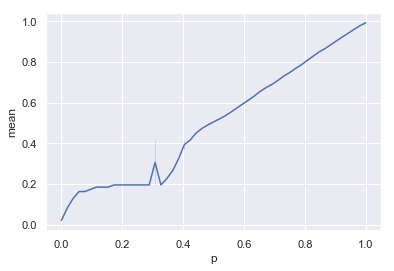

In [250]:
mean, var = m.predict_y(X)
normalized_df['mean'] = mean
print(normalized_df.head())
sns.lineplot(x='p', y='mean', data=normalized_df)

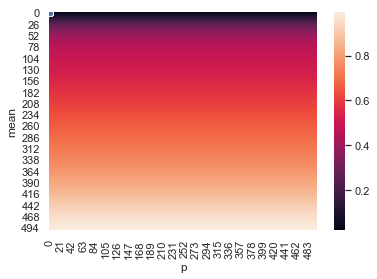

In [244]:
# Plot of posterior mean
latmax = X[:,0].max()
latmin = X[:,0].min()
longmax = X[:,1].min()
longmin = X[:,1].max()

xlist = np.linspace(latmin, latmax, 500)
ylist = np.linspace(longmin, longmax, 500)
xx, yy = np.meshgrid(xlist, ylist)
grid = np.array([np.reshape(xx,(-1,)).T,np.reshape(yy,(-1,))]).T

mean, var = m.predict_y(grid)

#grid2 = (mean.reshape(500,500) / abs(mean).max())
#print(grid2)
#sns.scatterplot(x="lat", y="long", data=seg2)
p1 = sns.heatmap(mean.reshape(500,500)) # , vmin= 0, vmax=1)
p2 = sns.scatterplot(x='p', y='mean', data=normalized_df)
#plt.xlim(latmin, latmax)
#plt.ylim(longmin, longmax)

#print(mean.reshape(500,500))
#plt.ylim(X[:,1].min(), X[:,1].max())
#plt.xlim(X[:,0].min(), X[:,0].max())

In [162]:
np.random.seed(0)
df = pd.DataFrame({'x' : xlist, "y" : ylist, "z":mean})
print(df)
binsx = np.arange(0,112.5,12.5)
binsy = np.arange(0,120,20)
res = df.groupby([pd.cut(df.y, binsy),pd.cut(df.x,binsx)])['z'].mean().unstack()

plt.imshow(res, cmap=plt.cm.Reds, 
           extent=[binsx.min(), binsx.max(),binsy.min(),binsy.max()])
plt.xticks(binsx)
plt.yticks(binsy)
plt.colorbar()
plt.grid(False)


plt.show()


(500,)


Exception: Data must be 1-dimensional